# Time Series Forecasting
## Using Machine Learning to Forecast Energy Consumption

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

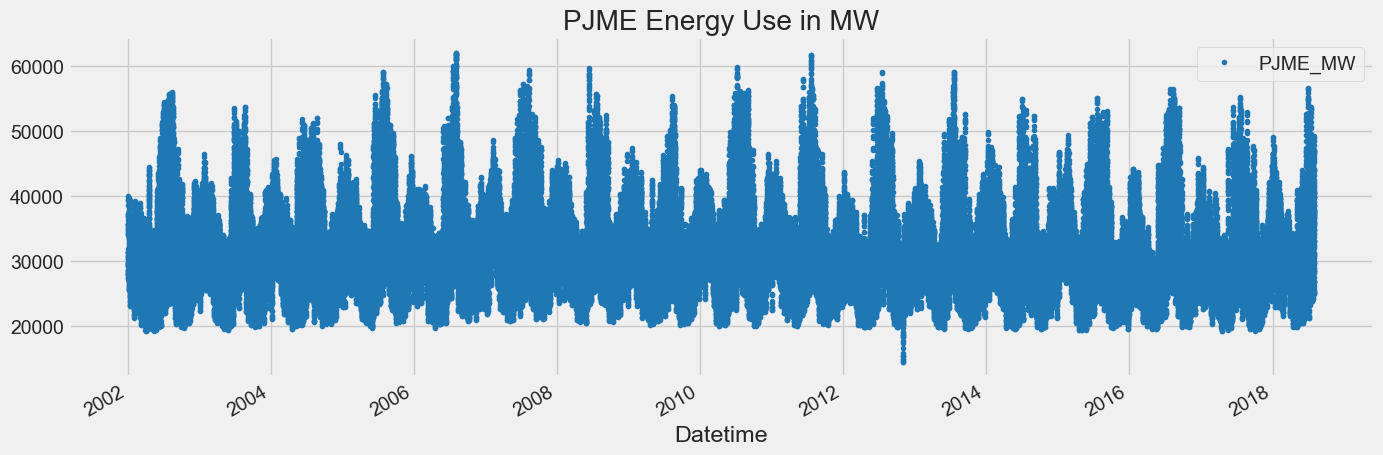

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# 1. Outlier Analysis and removal

<Axes: ylabel='Frequency'>

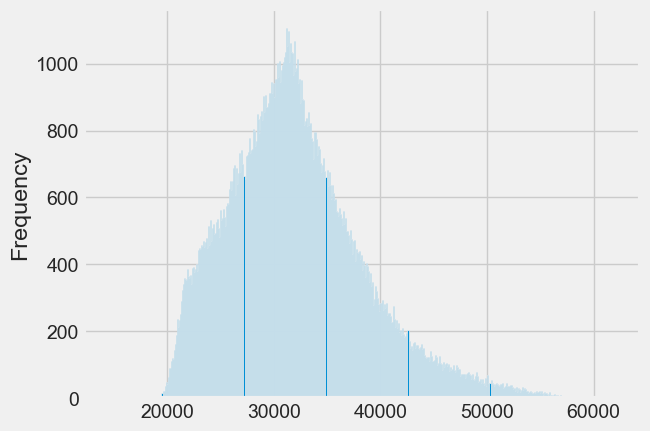

In [5]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

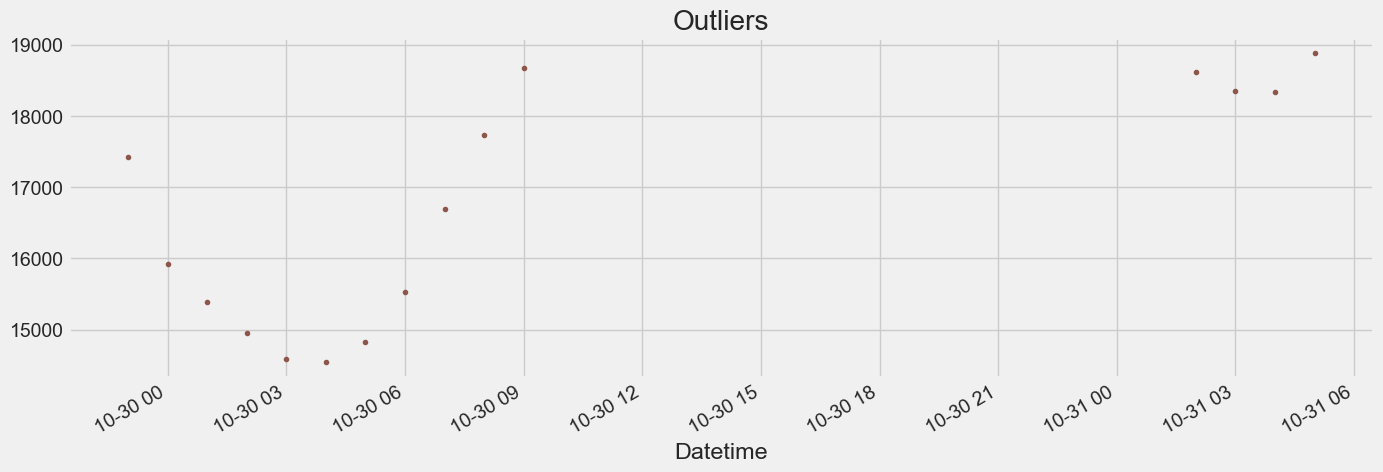

In [6]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [7]:
df = df.query('PJME_MW > 19_000').copy()

# Reviewing: Train / Test Split

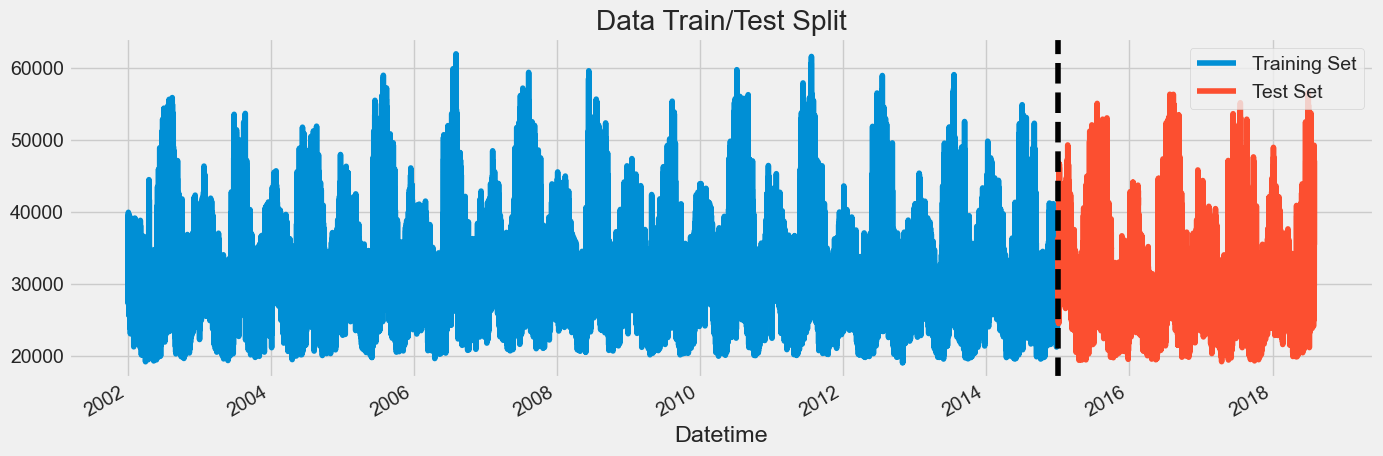

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation
Bir veri setini sadece eğitim ve test verisi olarak ikiye bölmek, bazı verilerin modelin eğitiminde kullanılmamasına neden olabilir. Bu durumda, model belirli verilere aşırı uyum sağlayabilir (overfitting). CV, veriyi birden fazla alt küme (katman) halinde böler ve her bir alt küme sırayla test verisi olarak kullanılır. Bu sayede, her veri öğesi modelin eğitim ve testinde en az bir kez yer alır.

In [9]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

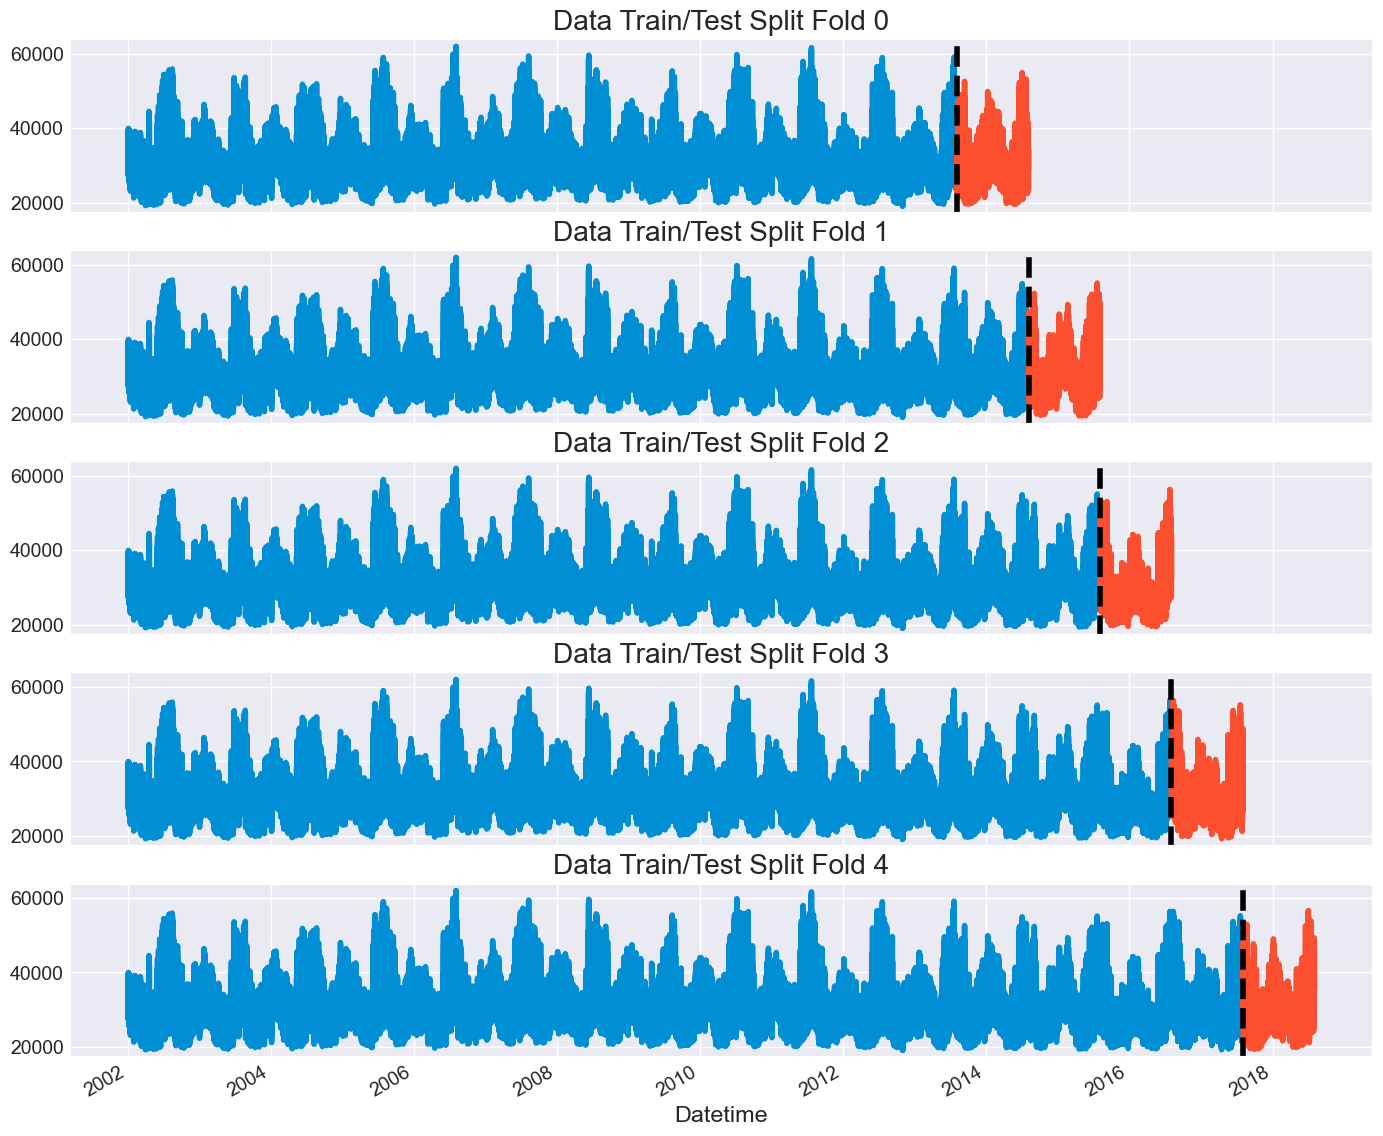

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
Datetime,,,,,,,,,,,,,
2017-08-03 01:00:00,29189.0,1,3,3,8,2017,215,3,31,28809.0,29952.0,28465.0,False
2017-08-03 02:00:00,27584.0,2,3,3,8,2017,215,3,31,27039.0,27934.0,26712.0,False
2017-08-03 03:00:00,26544.0,3,3,3,8,2017,215,3,31,25881.0,26659.0,25547.0,False
2017-08-03 04:00:00,26012.0,4,3,3,8,2017,215,3,31,25300.0,25846.0,24825.0,False
2017-08-03 05:00:00,26187.0,5,3,3,8,2017,215,3,31,25412.0,25898.0,24927.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,False
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,False
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,False


In [26]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()
test

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31


# 3. Lag Features
- What was the target (x) days in the past.
- Bir zaman serisi verisindeki lag, mevcut zaman noktasından önce gelen bir zaman noktasını ifade eder. Lag features ise, mevcut zamandaki değerleri önceki zaman noktalarındaki değerlerle ilişkilendiren özniteliklerdir. Bu öznitelikler, geçmiş değerlerin mevcut değeri tahmin etmede nasıl bir rol oynayabileceğini yakalamak için kullanılır.  Yani, verinin önceki zaman dilimlerine bakarak mevcut değeri tahmin etmek amacıyla kullanılan bir tür özniteliktir. Diyelim ki 2023-08-03 tarihindeki sıcaklığı tahmin etmek istiyoruz. Lag features kullanarak bu tahmini yapabiliriz. Eğer "lag 1" kullanıyorsak, 2023-08-02 tarihindeki sıcaklığı bir önceki günün sıcaklığı olarak tahmin edebiliriz. Benzer şekilde, "lag 2" kullanıyorsak, 2023-08-01 tarihindeki sıcaklığı iki gün önceki sıcaklık olarak tahmin edebiliriz.

In [12]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()  # target = PJME_MW
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    print(df['lag1'])
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    print(df['lag2'])
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    print(df['lag3'])
    return df

In [13]:
target_map = df['PJME_MW'].to_dict()  # target = PJME_MW

Index([    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,
       ...
       42993.0, 43279.0, 43216.0, 42707.0, 41387.0, 40182.0, 39434.0, 38033.0,
       35368.0, 32551.0],
      dtype='float64', name='Datetime', length=145351)

In [14]:
df = add_lags(df)
df

Datetime
2002-01-01 01:00:00        NaN
2002-01-01 02:00:00        NaN
2002-01-01 03:00:00        NaN
2002-01-01 04:00:00        NaN
2002-01-01 05:00:00        NaN
                        ...   
2018-08-02 20:00:00    42256.0
2018-08-02 21:00:00    41210.0
2018-08-02 22:00:00    39525.0
2018-08-02 23:00:00    36490.0
2018-08-03 00:00:00    33539.0
Name: lag1, Length: 145351, dtype: float64
Datetime
2002-01-01 01:00:00        NaN
2002-01-01 02:00:00        NaN
2002-01-01 03:00:00        NaN
2002-01-01 04:00:00        NaN
2002-01-01 05:00:00        NaN
                        ...   
2018-08-02 20:00:00    41485.0
2018-08-02 21:00:00    40249.0
2018-08-02 22:00:00    38698.0
2018-08-02 23:00:00    35406.0
2018-08-03 00:00:00    32094.0
Name: lag2, Length: 145351, dtype: float64
Datetime
2002-01-01 01:00:00        NaN
2002-01-01 02:00:00        NaN
2002-01-01 03:00:00        NaN
2002-01-01 04:00:00        NaN
2002-01-01 05:00:00        NaN
                        ...   
2018-08-02 20:00:00

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


## Train Using Cross Validation

In [28]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
test    

[16:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[457]	validation_0-rmse:3348.29869	validation_1-rmse:3761.08467
[16:30:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rms

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
Datetime,,,,,,,,,,,,,
2017-08-03 01:00:00,29189.0,1,3,3,8,2017,215,3,31,28809.0,29952.0,28465.0,False
2017-08-03 02:00:00,27584.0,2,3,3,8,2017,215,3,31,27039.0,27934.0,26712.0,False
2017-08-03 03:00:00,26544.0,3,3,3,8,2017,215,3,31,25881.0,26659.0,25547.0,False
2017-08-03 04:00:00,26012.0,4,3,3,8,2017,215,3,31,25300.0,25846.0,24825.0,False
2017-08-03 05:00:00,26187.0,5,3,3,8,2017,215,3,31,25412.0,25898.0,24927.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,False
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,False
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,False


In [16]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3750.6406
Fold scores:[3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.3608331481823, 3996.298054855067]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [17]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[15:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [18]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [19]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

2002-01-01 01:00:00        NaN
2002-01-01 02:00:00        NaN
2002-01-01 03:00:00        NaN
2002-01-01 04:00:00        NaN
2002-01-01 05:00:00        NaN
                        ...   
2019-07-31 20:00:00    46912.0
2019-07-31 21:00:00    45985.0
2019-07-31 22:00:00    44094.0
2019-07-31 23:00:00    40666.0
2019-08-01 00:00:00    37158.0
Name: lag1, Length: 154064, dtype: float64
2002-01-01 01:00:00        NaN
2002-01-01 02:00:00        NaN
2002-01-01 03:00:00        NaN
2002-01-01 04:00:00        NaN
2002-01-01 05:00:00        NaN
                        ...   
2019-07-31 20:00:00    39352.0
2019-07-31 21:00:00    38699.0
2019-07-31 22:00:00    37346.0
2019-07-31 23:00:00    34555.0
2019-08-01 00:00:00    31646.0
Name: lag2, Length: 154064, dtype: float64
2002-01-01 01:00:00        NaN
2002-01-01 02:00:00        NaN
2002-01-01 03:00:00        NaN
2002-01-01 04:00:00        NaN
2002-01-01 05:00:00        NaN
                        ...   
2019-07-31 20:00:00    40243.0
2019-07-31 21:0

In [20]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


## Predict the future

In [21]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

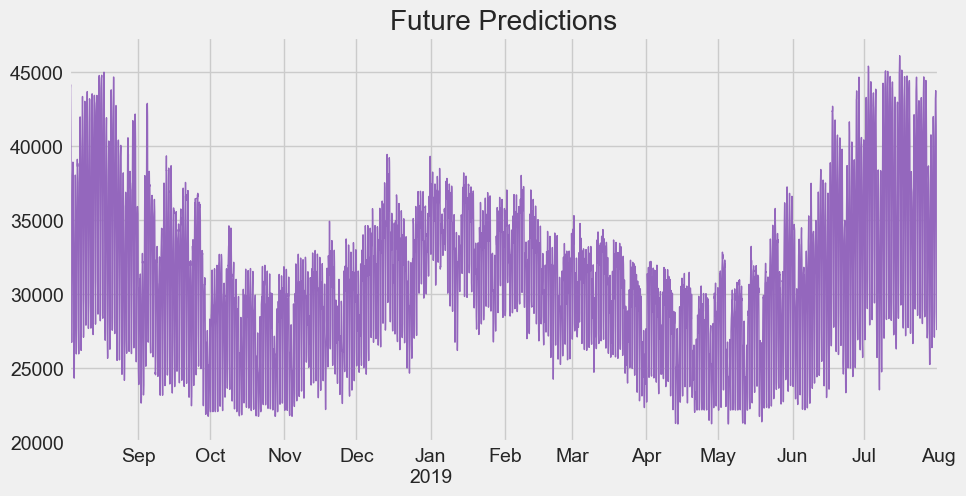

In [22]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Saving Model For later

In [23]:
# Save model
reg.save_model('model.json')

In [24]:
!ls -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.


<Axes: title={'center': 'Future Predictions'}>

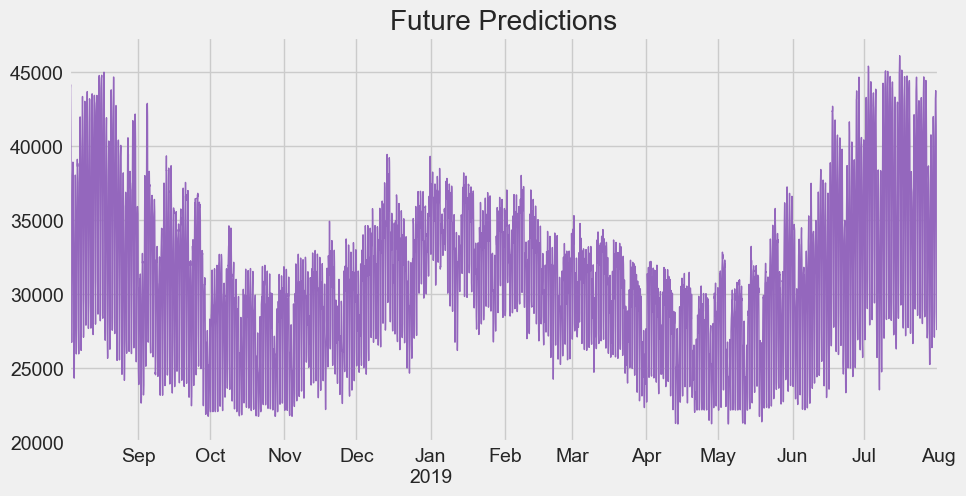

In [25]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')